In [130]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, recall_score, jaccard_score, precision_score
import matplotlib.pyplot as plt
from PIL import Image
import warnings

## Data Processing

In [131]:
class Process_Datasets(Dataset):
    def __init__(self, root_dir, image_processor):
        self.root_dir = root_dir
        self.image_processor = image_processor

        self.image_path = os.path.join(self.root_dir, "images")
        self.mask_path = os.path.join(self.root_dir, "masks")

        image_files = [f for f in os.listdir(self.image_path) if '.png' in f]
        mask_files = [f for f in os.listdir(self.mask_path) if '.png' in f]
        self.images = sorted(image_files)
        self.masks = sorted(mask_files)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.image_path, self.images[index])
        mask_path = os.path.join(self.mask_path, self.masks[index])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        encoded = self.image_processor(image, mask, return_tensors="pt")

        for k,v in encoded.items():
            encoded[k].squeeze_()

        return encoded

In [132]:
pre_trained_model = 'nvidia/segformer-b0-finetuned-ade-512-512'
image_processor = SegformerImageProcessor(do_reduce_labels=False, do_resize=True, do_normalize=True, size=(256,256))

def load_datasets(root_dir):
    batch_size=4

    dataset = Process_Datasets(root_dir=root_dir, image_processor=image_processor)
    train, val = train_test_split(dataset, test_size=0.2, random_state=42)
    val, test = train_test_split(val, test_size=0.01, random_state=42)

    train_dataset = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataset = DataLoader(val, batch_size=batch_size, shuffle=True)
    test_dataset = DataLoader(test, shuffle=True)

    return train_dataset, val_dataset, test_dataset

In [133]:
covid_train, covid_val, covid_test = load_datasets(root_dir="./COVID-19/COVID")
len(covid_train), len(covid_val), len(covid_test)

(723, 179, 8)

In [134]:
pneumonia_train, pneumonia_val, pneumonia_test = load_datasets(root_dir="./COVID-19/Viral Pneumonia")
len(pneumonia_train), len(pneumonia_val), len(pneumonia_test)

(269, 67, 3)

## Model Implementation

In [135]:
def warn(*args, **kwargs):
    pass

warnings.warn = warn

def avg_metrics(accuracy, precision, recall, dice, iou):
    avg_iou = np.mean(iou)
    avg_accur = np.mean(accuracy)
    avg_prec = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_dice = np.mean(dice)

    df = pd.DataFrame({
        'Metrics': ['Accuracy', 'Precision', 'Recall', 'Dice Coef', 'IoU'],
        'Values': [avg_accur, avg_prec, avg_recall, avg_dice, avg_iou]
    })

    display(df)

In [136]:
def train_model(train_data, val_data):
    epochs = 20

    model = SegformerForSemanticSegmentation.from_pretrained(pre_trained_model, ignore_mismatched_sizes=True)
    optimizer = optim.Adam(model.parameters(), lr=1e-6)
    training_losses = []
    validation_losses = []

    accuracy = []
    precision = []
    recall = [] 
    dice = [] 
    iou = []

    # Train network
    for ep in range(epochs):
        train_loss = []
        val_loss = []

        model.train()
        for index, batch in enumerate(tqdm(train_data)):
            image = batch["pixel_values"]
            mask = batch["labels"]
            optimizer.zero_grad()
            
            outputs = model(pixel_values=image, labels=mask)

            loss = outputs.loss
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for index, batch in enumerate(tqdm(val_data)):
                image = batch["pixel_values"]
                mask = batch["labels"]
                optimizer.zero_grad()

                outputs = model(pixel_values=image, labels=mask)
                logits = F.interpolate(outputs.logits, size=mask.shape[-2:], mode="bilinear", align_corners=False)
                prediction = logits.argmax(dim=1)

                for pred, true in zip(prediction, mask):
                    pred_mask = pred.cpu().numpy()
                    true_mask = true.cpu().numpy()

                    accuracy.append(accuracy_score(true_mask.flatten(), pred_mask.flatten()))
                    precision.append(precision_score(true_mask.flatten(), pred_mask.flatten(), average='weighted'))
                    recall.append(recall_score(true_mask.flatten(), pred_mask.flatten(), average='weighted'))
                    dice.append(f1_score(true_mask.flatten(), pred_mask.flatten(), average='weighted'))
                    iou.append(jaccard_score(true_mask.flatten(), pred_mask.flatten(), average='weighted'))
                    
                loss = outputs.loss
                val_loss.append(loss.item())
                optimizer.step()

        training_losses.append(np.mean(train_loss))
        validation_losses.append(np.mean(val_loss))
        print(f"Epoch [{ep+1}/{epochs}]. Training Loss [{np.mean(train_loss)}]. Validation Loss [{np.mean(val_loss)}]")

    avg_metrics(accuracy, precision, recall, dice, iou)
    
    plt.figure(figsize=(5,5))
    plt.plot(training_losses, label="Training")
    plt.plot(validation_losses,label="Validation")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss Values")
    plt.legend()
    plt.show()
    
    return model

### 1/ Covid-19 Dataset

100%|██████████| 179/179 [01:29<00:00,  2.00it/s]


Epoch [1/20]. Training Loss [1.2924769836507561]. Validation Loss [0.7405016617069031]


100%|██████████| 179/179 [01:28<00:00,  2.03it/s]


Epoch [2/20]. Training Loss [0.6938707657869426]. Validation Loss [0.5162533539966498]


100%|██████████| 179/179 [01:29<00:00,  2.00it/s]


Epoch [3/20]. Training Loss [0.4430545315785362]. Validation Loss [0.33670043112845394]


100%|██████████| 179/179 [01:29<00:00,  2.01it/s]


Epoch [4/20]. Training Loss [0.29682325550134747]. Validation Loss [0.2476641125352689]


100%|██████████| 179/179 [01:28<00:00,  2.02it/s]


Epoch [5/20]. Training Loss [0.20881431204566983]. Validation Loss [0.17737779653938124]


100%|██████████| 179/179 [01:29<00:00,  2.00it/s]


Epoch [6/20]. Training Loss [0.14981475208639933]. Validation Loss [0.1252384296092907]


100%|██████████| 179/179 [01:29<00:00,  2.01it/s]


Epoch [7/20]. Training Loss [0.10653703502104984]. Validation Loss [0.08873961834684431]


100%|██████████| 179/179 [01:29<00:00,  2.01it/s]


Epoch [8/20]. Training Loss [0.07865295708591677]. Validation Loss [0.058530268077244305]


100%|██████████| 179/179 [01:29<00:00,  2.00it/s]


Epoch [9/20]. Training Loss [0.06135054758877428]. Validation Loss [0.056287967251332775]


100%|██████████| 179/179 [01:32<00:00,  1.93it/s]


Epoch [10/20]. Training Loss [0.048306584993266545]. Validation Loss [0.039784443413828335]


100%|██████████| 179/179 [01:28<00:00,  2.03it/s]


Epoch [11/20]. Training Loss [0.03698930726547624]. Validation Loss [0.02973350044860187]


100%|██████████| 179/179 [01:28<00:00,  2.01it/s]


Epoch [12/20]. Training Loss [0.0297394494627851]. Validation Loss [0.02813850382769574]


100%|██████████| 179/179 [01:28<00:00,  2.03it/s]


Epoch [13/20]. Training Loss [0.023845164581262512]. Validation Loss [0.019807547591002294]


100%|██████████| 179/179 [01:41<00:00,  1.77it/s]


Epoch [14/20]. Training Loss [0.019033501363960953]. Validation Loss [0.01750342866832484]


100%|██████████| 179/179 [01:29<00:00,  2.00it/s]


Epoch [15/20]. Training Loss [0.015711045829143844]. Validation Loss [0.012096756468292887]


100%|██████████| 179/179 [01:28<00:00,  2.02it/s]


Epoch [16/20]. Training Loss [0.012834742404765257]. Validation Loss [0.009626786921735249]


100%|██████████| 179/179 [01:29<00:00,  2.01it/s]


Epoch [17/20]. Training Loss [0.01089911867818057]. Validation Loss [0.00875157065033996]


100%|██████████| 179/179 [01:28<00:00,  2.03it/s]


Epoch [18/20]. Training Loss [0.009014830146053159]. Validation Loss [0.005960620726411902]


100%|██████████| 179/179 [01:28<00:00,  2.02it/s]


Epoch [19/20]. Training Loss [0.007309766153947941]. Validation Loss [0.007342254576486582]


100%|██████████| 179/179 [01:27<00:00,  2.05it/s]

Epoch [20/20]. Training Loss [0.0062231300067012284]. Validation Loss [0.004383984118096489]


,Metrics,Values
0,Accuracy,0.741271
1,Precision,0.687005
2,Recall,0.741271
3,Dice Coef,0.711607
4,IoU,0.675325


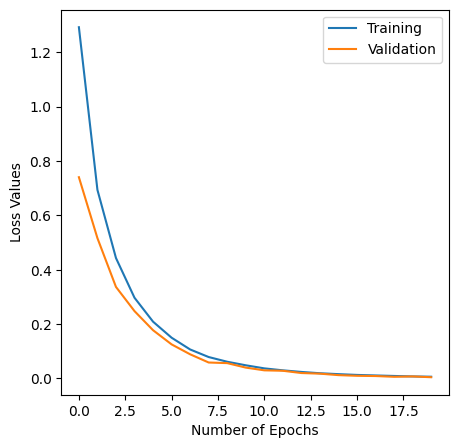

In [137]:
covid_model = train_model(covid_train, covid_val)

### 2/ Pneumonia Datasets

100%|██████████| 67/67 [00:32<00:00,  2.08it/s]


Epoch [1/20]. Training Loss [1.36778047647618]. Validation Loss [1.0810722326164814]


100%|██████████| 67/67 [00:32<00:00,  2.07it/s]


Epoch [2/20]. Training Loss [0.9469662058309108]. Validation Loss [0.8276240665521195]


100%|██████████| 67/67 [00:32<00:00,  2.08it/s]


Epoch [3/20]. Training Loss [0.7441359507993252]. Validation Loss [0.6310842468667386]


100%|██████████| 67/67 [00:32<00:00,  2.07it/s]


Epoch [4/20]. Training Loss [0.5957036873664998]. Validation Loss [0.6002945237195314]


100%|██████████| 67/67 [00:32<00:00,  2.03it/s]


Epoch [5/20]. Training Loss [0.507995609124797]. Validation Loss [0.4778277740549685]


100%|██████████| 67/67 [00:33<00:00,  2.03it/s]


Epoch [6/20]. Training Loss [0.43855612096290164]. Validation Loss [0.471583168453245]


100%|██████████| 67/67 [00:32<00:00,  2.08it/s]


Epoch [7/20]. Training Loss [0.38569998486334506]. Validation Loss [0.3507747507807034]


100%|██████████| 67/67 [00:31<00:00,  2.10it/s]


Epoch [8/20]. Training Loss [0.33293209787195055]. Validation Loss [0.3671744883950077]


100%|██████████| 67/67 [00:32<00:00,  2.04it/s]


Epoch [9/20]. Training Loss [0.2963632386191627]. Validation Loss [0.31058690952720924]


100%|██████████| 67/67 [00:32<00:00,  2.03it/s]


Epoch [10/20]. Training Loss [0.26186695822331096]. Validation Loss [0.2994199459677312]


100%|██████████| 67/67 [00:32<00:00,  2.03it/s]


Epoch [11/20]. Training Loss [0.23797806294212553]. Validation Loss [0.23858286173485999]


100%|██████████| 67/67 [00:33<00:00,  2.02it/s]


Epoch [12/20]. Training Loss [0.21754152025875106]. Validation Loss [0.22888990035697596]


100%|██████████| 67/67 [00:32<00:00,  2.04it/s]


Epoch [13/20]. Training Loss [0.19025507896141491]. Validation Loss [0.17054598255833583]


100%|██████████| 67/67 [00:32<00:00,  2.05it/s]


Epoch [14/20]. Training Loss [0.17174769486525687]. Validation Loss [0.1825868100372713]


100%|██████████| 67/67 [00:32<00:00,  2.04it/s]


Epoch [15/20]. Training Loss [0.15266635878267784]. Validation Loss [0.1497793443389793]


100%|██████████| 67/67 [00:32<00:00,  2.03it/s]


Epoch [16/20]. Training Loss [0.13938088382708538]. Validation Loss [0.12154502099129691]


100%|██████████| 67/67 [00:33<00:00,  2.02it/s]


Epoch [17/20]. Training Loss [0.1236322367612314]. Validation Loss [0.10567995372103221]


100%|██████████| 67/67 [00:32<00:00,  2.04it/s]


Epoch [18/20]. Training Loss [0.11035412764626808]. Validation Loss [0.10164455013043845]


100%|██████████| 67/67 [00:32<00:00,  2.04it/s]


Epoch [19/20]. Training Loss [0.10031587324454883]. Validation Loss [0.1008942845597196]


100%|██████████| 67/67 [00:33<00:00,  2.01it/s]

Epoch [20/20]. Training Loss [0.09273540019490462]. Validation Loss [0.0839450297070973]


,Metrics,Values
0,Accuracy,0.735429
1,Precision,0.704898
2,Recall,0.735429
3,Dice Coef,0.716752
4,IoU,0.678998


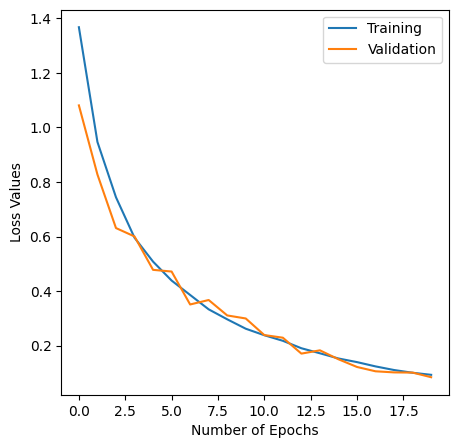

In [138]:
pneumonia_model = train_model(pneumonia_train, pneumonia_val)

## Results Illustration

In [139]:
def image_display(model, test_data):
    for index, batch in enumerate(tqdm(test_data)):
        image = batch["pixel_values"]
        mask = batch["labels"]

        outputs = model(image)
        prediction = torch.argmax(outputs.logits, 1)
        
        image = image.squeeze()
        fig, ax = plt.subplots(1, 3, figsize=(12, 8))
        ax[0].imshow(image.permute(1, 2, 0))
        ax[1].imshow(mask.permute(1, 2, 0))
        ax[2].imshow(prediction.permute(1, 2, 0))

        ax[0].set_title(f'Test Image')
        ax[1].set_title(f'True Mask')
        ax[2].set_title(f'Predicted Mask')

### 1/ Covid-19 Datasets

 25%|██▌       | 2/8 [00:00<00:00,  8.11it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 50%|█████     | 4/8 [00:00<00:00, 10.47it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 75%|███████▌  | 6/8 [00:00<00:00, 11.53it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 8/8 [00:00<00:00, 11.06it/s]


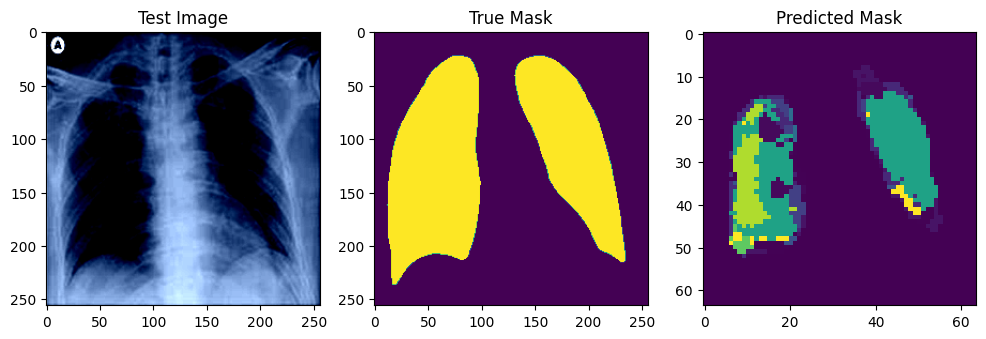

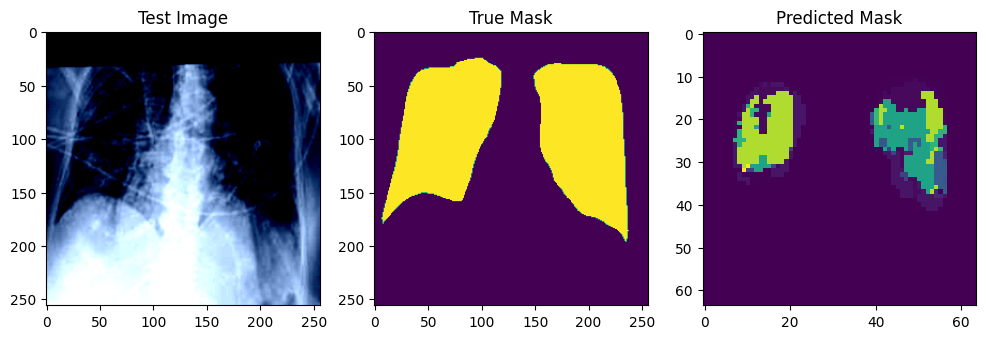

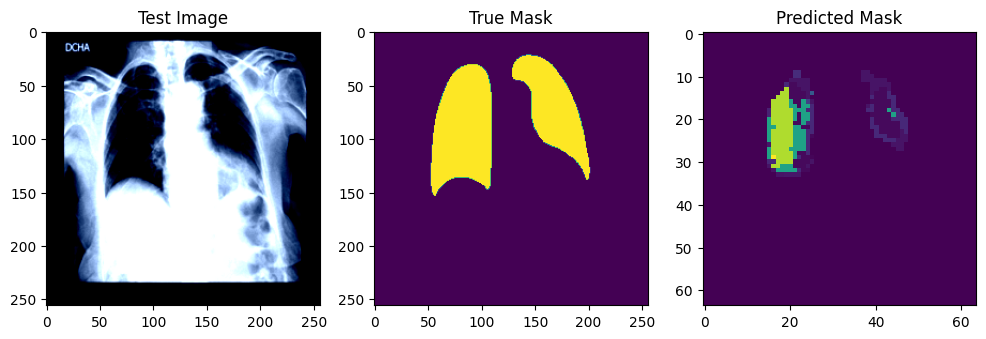

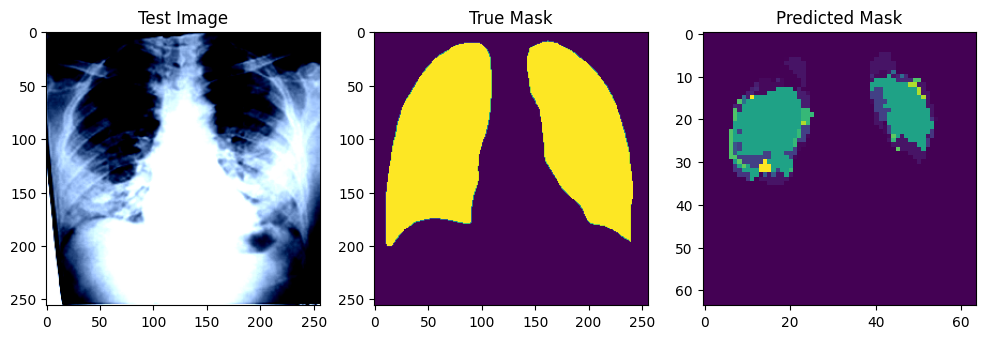

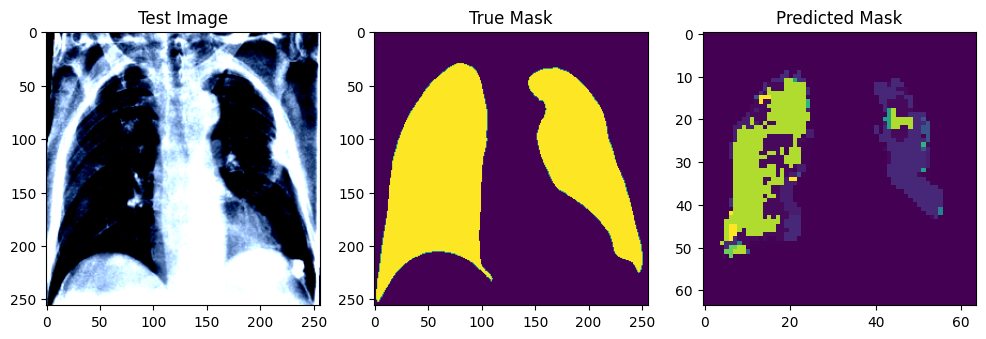

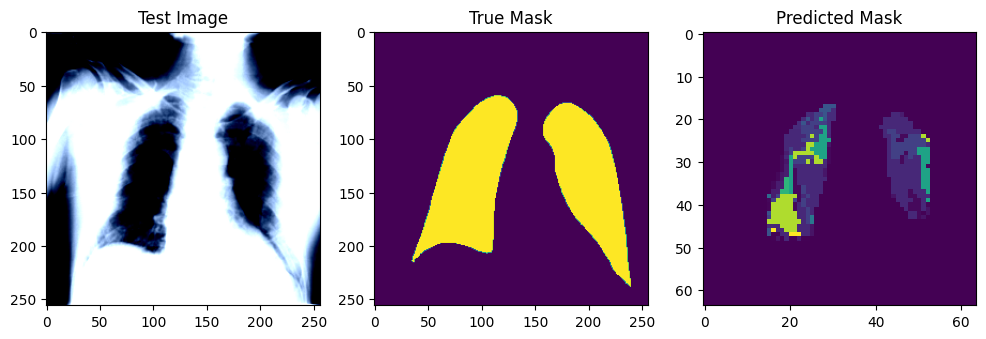

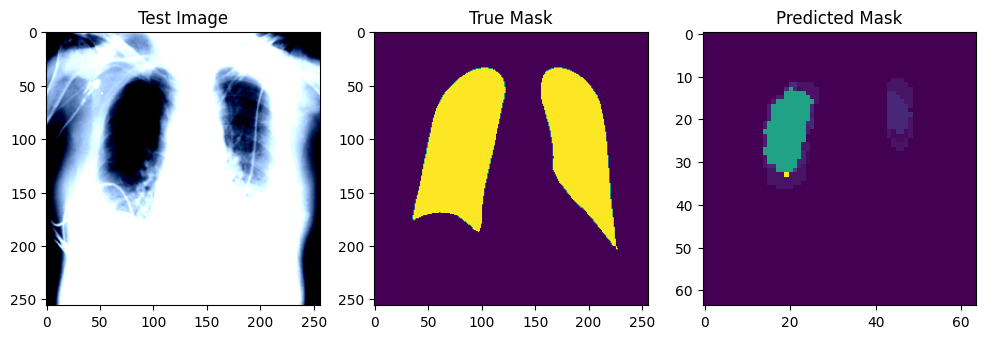

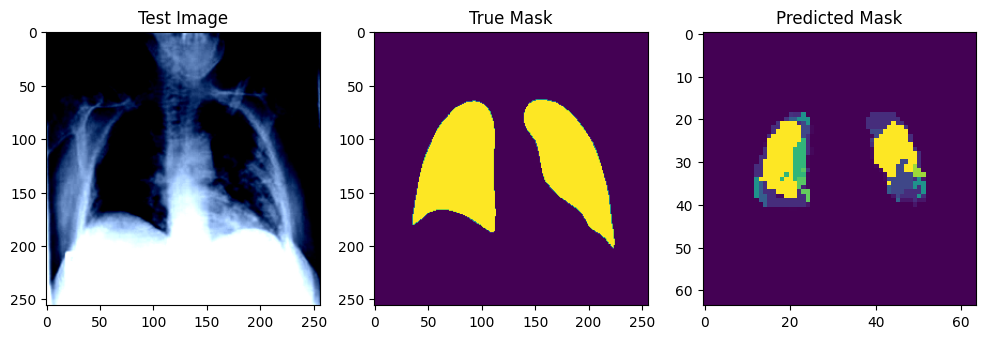

In [140]:
image_display(covid_model, covid_test)

### 2/ Pneumonia Datasets

  0%|          | 0/3 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 3/3 [00:00<00:00, 12.88it/s]


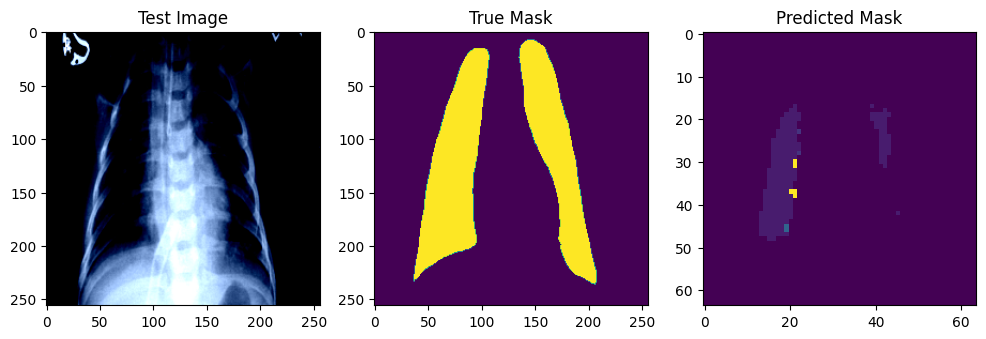

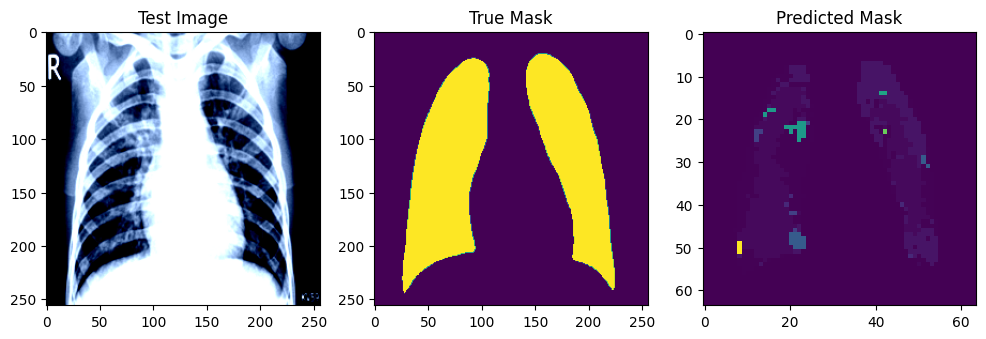

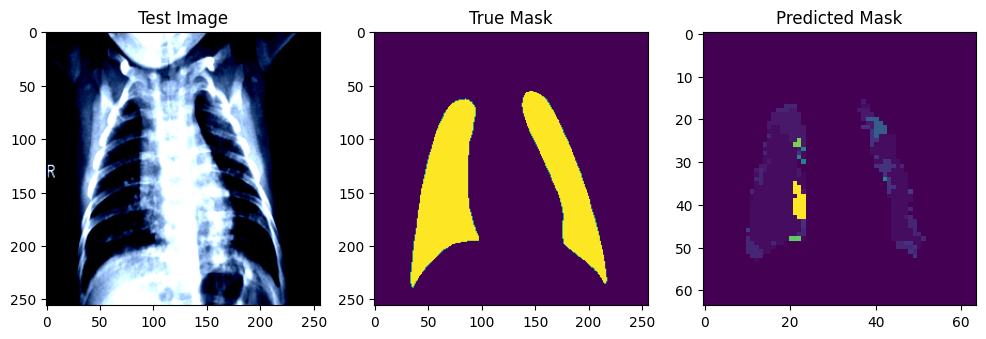

In [141]:
image_display(pneumonia_model, pneumonia_test)